In [44]:
import sys
import string
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS
from sklearn import feature_extraction
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans, AffinityPropagation
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.decomposition import PCA, KernelPCA
from sklearn import decomposition

import mpld3
from pathlib import Path
from collections import Counter
sys.path.insert(0, '..')
from src import helper

In [48]:
# data = np.load('../model/train_matrix.npz')
data = np.load('../model/train_test_precomputed_norm_matrix_w2v.npz')
X_train = data['X_train']
y_train = data['y_train']
X_test = data['X_test']
y_test = data['y_test']

In [47]:
# choose random 3000 documents
idx = np.random.randint(y_train.shape[0], size=3000)
print(Counter([y_train[i] for i in idx]))
X_train = X_train[idx, :]
y_train = y_train[idx]

Counter({1: 1124, 2: 972, 0: 904})


In [49]:
X_train.shape
y_train.shape

(72140,)

In [50]:
# X_train[0]

In [51]:
# X_train = preprocessing.normalize(X_train, norm='l2', axis=1, copy=True, return_norm=False)
# X_train[0]

## Cluster

### Cluster without dimension reduction

In [5]:
num_clusters = 3

km = KMeans(n_clusters=num_clusters)

%time km.fit(X_train)

clusters = km.labels_.tolist()

data = {'y_train': y_train, 'cluster': clusters}
df = pd.DataFrame(data, columns=['y_train', 'cluster'])
df['cluster'].value_counts() #number of document per cluster (clusters from 0 to 2)

CPU times: user 1.84 s, sys: 2.25 s, total: 4.09 s
Wall time: 1.43 s


0    4824
2    4070
1    1106
Name: cluster, dtype: int64

### Cluster with PCA

In [6]:
pca = PCA(n_components=2)
X_new = pca.fit_transform(X_train)

num_clusters = 3
km = KMeans(n_clusters=num_clusters)

%time km.fit(X_new)

clusters = km.labels_.tolist()

data = {'y_train': y_train, 'cluster': clusters}
df = pd.DataFrame(data, columns=['y_train', 'cluster'])
df['cluster'].value_counts() #number of document per cluster (clusters from 0 to 2)

CPU times: user 219 ms, sys: 250 ms, total: 469 ms
Wall time: 140 ms


1    4940
0    3909
2    1151
Name: cluster, dtype: int64

### Cluster with KernelPCA

In [ ]:
for kernel in ['linear', 'poly', 'rbf', 'sigmoid', 'cosine']:
    print('kernel: ', str.upper(kernel))
    kPca = KernelPCA(kernel=kernel)
    X_new = kPca.fit_transform(X_train)

    num_clusters = 3
    km = KMeans(n_clusters=num_clusters)

    %time km.fit(X_new)

    clusters = km.labels_.tolist()

    data = {'y_train': y_train, 'cluster': clusters}
    df = pd.DataFrame(data, columns=['y_train', 'cluster'])
    print(df['cluster'].value_counts()) #number of document per cluster (clusters from 0 to 2)

### Cluster using AffinityPropagation

In [30]:
aff = AffinityPropagation(verbose=True)
y_pred = aff.fit_predict(X_train)
print(len(aff.cluster_centers_))
# print(aff.cluster_centers_indices_)

Converged after 84 iterations.
188


In [36]:
cluster_of_label = dict()
for p, t in zip(y_pred, y_train):
    if t in cluster_of_label.keys():
        cluster_of_label[t].append(p)
    else:
        cluster_of_label[t] = [p]

print('label[0] - label[1]:\ncluster: %s\n' % (set(cluster_of_label[0]).intersection(cluster_of_label[1])))
print('label[0] - label[2]:\ncluster: %s\n' % (set(cluster_of_label[0]).intersection(cluster_of_label[2])))    

label[0] - label[1]:
cluster: {128, 129, 131, 132, 134, 6, 8, 137, 7, 11, 12, 140, 141, 136, 16, 145, 18, 146, 147, 143, 23, 25, 154, 27, 157, 30, 159, 29, 33, 163, 36, 165, 38, 164, 168, 173, 175, 176, 49, 178, 180, 181, 52, 182, 184, 186, 59, 61, 62, 63, 66, 70, 74, 76, 80, 84, 90, 92, 93, 95, 97, 100, 103, 104, 113, 116, 117, 118, 120, 121, 122, 125}

label[0] - label[2]:
cluster: {128, 129, 131, 132, 134, 136, 137, 8, 11, 12, 140, 143, 18, 147, 23, 24, 25, 154, 29, 157, 30, 159, 33, 163, 164, 165, 38, 168, 169, 173, 176, 49, 178, 52, 181, 180, 182, 184, 186, 59, 61, 62, 63, 66, 70, 74, 76, 82, 84, 85, 90, 92, 93, 95, 97, 100, 103, 104, 107, 113, 116, 117, 118, 120, 121, 125}



In [ ]:
Counter(clusters)

In [36]:
confusion_matrix(y_train, clusters)

array([[316,  82,  52],
       [141, 357,  73],
       [257, 173,  49]])

## Visualization

In [13]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3'}

#set up cluster names using a dict
cluster_names = {0: 'negative', 
                 1: 'neutral', 
                 2: 'positive'}

def viz(xs, ys, clusters, title, file_name):
    #some ipython magic to show the matplotlib plots inline
    %matplotlib inline 

    #create data frame that has the result of the MDS plus the cluster numbers and titles
    mdf_df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=title)) 
    # mdf_df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=y_train)) 

    #group by cluster
    groups = mdf_df.groupby('label')


    # set up plot
    fig, ax = plt.subplots(figsize=(17, 9)) # set size
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

    #iterate through groups to layer the plot
    #note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
    for name, group in groups:
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
                label=cluster_names[name], color=cluster_colors[name], 
                mec='none')
        ax.set_aspect('auto')
        ax.tick_params(\
            axis= 'x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelbottom='off')
        ax.tick_params(\
            axis= 'y',         # changes apply to the y-axis
            which='both',      # both major and minor ticks are affected
            left='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelleft='off')

    ax.legend(numpoints=1)  #show legend with only 1 point

    #add label in x,y position with the label as the film title
    for i in range(len(mdf_df)):
        ax.text(mdf_df.loc[i]['x'], mdf_df.loc[i]['y'], mdf_df.loc[i]['title'], size=8)  


    plt.show() #show the plot

    fig.savefig(str(Path('../output/%s.png' % file_name)), dpi=200)

## Multidimensional scaling

In [9]:
dist = 1 - cosine_similarity(X_train)
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


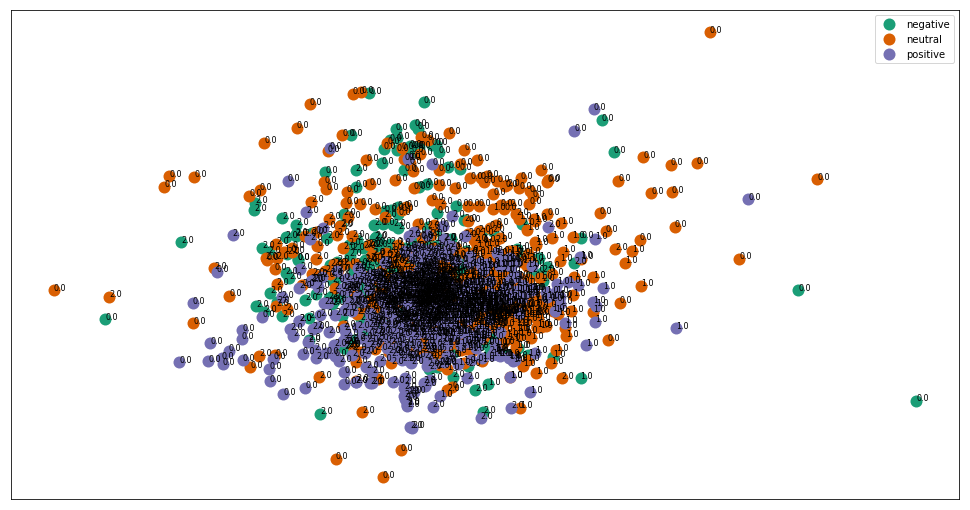

In [14]:
viz(xs, ys, y_train, clusters, 'clusters_sentiment_MDS')

### PCA

In [15]:
pca = PCA(n_components=2)
X_new = pca.fit_transform(X_train)
xs, ys = X_new[:, 0], X_new[:, 1]

/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


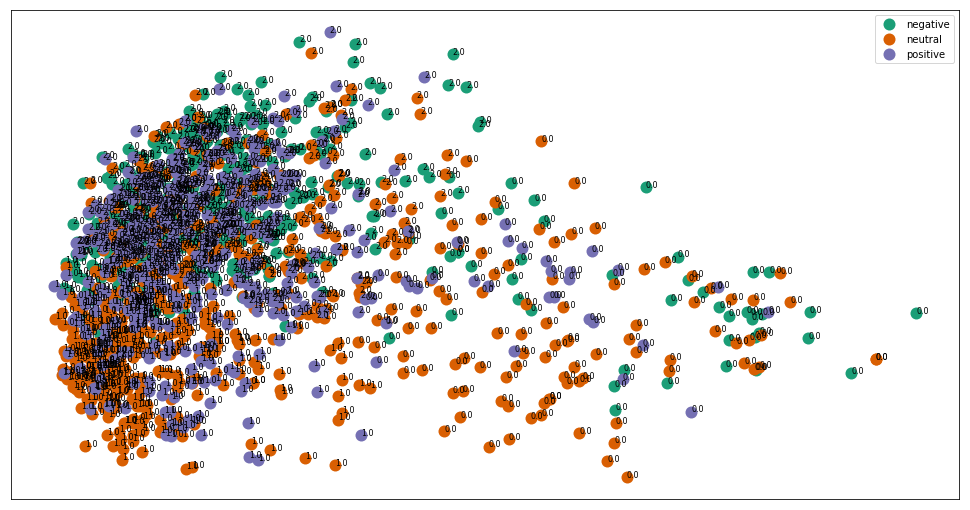

In [16]:
viz(xs, ys, y_train, clusters, 'clusters_sentiment_PCA')

## Ensemble learning

In [80]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV

In [76]:
clf = RandomForestClassifier(n_estimators=100)
%time clf.fit(X_train, y_train)

CPU times: user 1min 50s, sys: 219 ms, total: 1min 50s
Wall time: 1min 51s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [77]:
# train data
y_pred = clf.predict(X_train)
accuracy = np.mean(y_pred.ravel() == y_train.ravel()) * 100
print('Accuracy: %.1f' % accuracy)
confusion_matrix(y_train, y_pred)

Accuracy: 99.9


array([[21524,    10,     1],
       [    1, 27688,    20],
       [    3,    19, 22874]])

In [78]:
# test data
y_pred = clf.predict(X_test)
for i in range(X_test.shape[0]):
    if X_test[i].sum() == 0:
        y_pred[i] = 1
accuracy = np.mean(y_pred.ravel() == y_test.ravel()) * 100
print('Accuracy: %.1f' % accuracy)
confusion_matrix(y_test, y_pred)

Accuracy: 77.0


array([[7780,  875,  608],
       [1116, 8813, 1649],
       [ 938, 1817, 6874]])

In [81]:
clf1 = RandomForestClassifier(n_estimators=100)
clf2 = AdaBoostClassifier(n_estimators=100)
clf3 = KNeighborsClassifier(n_neighbors=10)
clf4 = LogisticRegressionCV(Cs=10, solver='newton-cg', multi_class='multinomial', class_weight=None, penalty='l2')
clf5 = GaussianNB()
eclf = VotingClassifier(estimators=[('rf', clf1), ('ab', clf2), ('knn', clf3), ('lr', clf4), ('gnb', clf5)], voting='hard')

In [ ]:
from sklearn.model_selection import cross_val_score
for clf, label in zip([clf1, clf2, clf3, clf4, clf5, eclf], 
                      ['Random Forest', 'AdaBoost', 'KNN', 'Logistic Regression', 'naive Bayes', 'Ensemble']):
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))
#     scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='precision')
#     print("Precision: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.77 (+/- 0.00) [Random Forest]
Accuracy: 0.71 (+/- 0.00) [AdaBoost]


In [ ]:
eclf = VotingClassifier(estimators=[('rf', clf1), ('ab', clf2), ('knn', clf3), ('lr', clf4), ('gnb', clf5)], voting='soft')
for clf, label in zip([clf1, clf2, clf3, clf4, clf5, eclf], 
                      ['Random Forest', 'AdaBoost', 'KNN', 'Logistic Regression', 'naive Bayes', 'Ensemble']):
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))
#     scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='precision')
#     print("Precision: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))